In [1]:
import os
import tensorflow as tf
from tensorflow.keras.layers import BatchNormalization, GlobalAveragePooling2D, Input, Conv2D, MaxPooling2D, Reshape, LSTM, Dense, Dropout, Bidirectional, Layer
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

2025-04-28 21:57:17.340471: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-28 21:57:17.353091: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745877437.368967    5010 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745877437.374106    5010 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-28 21:57:17.390891: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
np.random.seed(42)
tf.random.set_seed(42)

# Constants
IMAGE_SIZE = (224, 224)
INPUT_SHAPE = (*IMAGE_SIZE, 3)
BATCH_SIZE = 126
EPOCHS = 50
LATENT_DIM = 126
KL_WEIGHT = 0.0001

# Paths to dataset directories
BASE_DIR = "../../dataset/balanced/chest_xray"
TRAIN_DIR = os.path.join(BASE_DIR, "train")
VAL_DIR = os.path.join(BASE_DIR, "val")
TEST_DIR = os.path.join(BASE_DIR, "test")

In [3]:
# Data augmentation and preprocessing for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=False,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

# Only rescaling for validation and test data
test_datagen = ImageDataGenerator(rescale=1. / 255)

# Load training data first to determine class indices
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)


Found 4099 images belonging to 3 classes.


In [4]:
class_indices = train_generator.class_indices
class_names = list(class_indices.keys())
num_classes = len(class_names)

print(f"Detected classes: {class_names}")
print(f"Number of classes: {num_classes}")

Detected classes: ['BACTERIA', 'NORMAL', 'VIRUS']
Number of classes: 3


In [5]:
# load validation and test data with the same class indices
validation_generator = test_datagen.flow_from_directory(
    VAL_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=class_names,
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=class_names,
    shuffle=False
)

print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {validation_generator.samples}")
print(f"Test samples: {test_generator.samples}")


Found 586 images belonging to 3 classes.
Found 1173 images belonging to 3 classes.
Training samples: 4099
Validation samples: 586
Test samples: 1173


In [6]:
# A custom Sampling layer to handle the re parameterization
class Sampling(Layer):

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


In [7]:
# KL Loss Layer
class KLDivergenceLayer(Layer):
    def __init__(self, weight=KL_WEIGHT, **kwargs):
        self.weight = weight
        super(KLDivergenceLayer, self).__init__(**kwargs)

    def call(self, inputs):
        z_mean, z_log_var = inputs
        kl_loss = -0.5 * tf.reduce_mean(
            1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var),
            axis=-1
        )
        self.add_loss(self.weight * kl_loss)  # Apply weight to KL loss
        return inputs

    def compute_output_shape(self, input_shape):
        return input_shape



In [8]:
# VRNN Model
def vrnn_model(input_shape=INPUT_SHAPE, num_classes=num_classes):
    # Input layer
    inputs = Input(shape=input_shape)

    # CNN Encoder
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.2)(x)

    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.3)(x)

    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.4)(x)

    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)  # Instead of MaxPooling + Reshape

    # Reshape for RNN
    _, feature_h, feature_w, feature_c = x.shape
    x = Reshape((feature_h, feature_w * feature_c))(x)

    # Bidirectional LSTM (Encoder)
    x = Bidirectional(LSTM(256, return_sequences=True))(x)
    x = Bidirectional(LSTM(256))(x)

    # Variational Latent Space
    z_mean = Dense(LATENT_DIM*2, name='z_mean')(x)
    z_log_var = Dense(LATENT_DIM*2, name='z_log_var')(x)

    # Apply KL divergence
    KLDivergenceLayer()([z_mean, z_log_var])

    # Use custom Sampling layer
    z = Sampling()([z_mean, z_log_var])

    # Decoder (Dense layers)
    x = Dense(512, activation='relu')(z)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    # Define VRNN model
    model = Model(inputs, outputs)

    # Compile
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


In [9]:
# 1. SETUP Multi-GPU 
strategy = tf.distribute.MirroredStrategy()

print('Number of devices:', strategy.num_replicas_in_sync)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


I0000 00:00:1745877440.434198    5010 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78765 MB memory:  -> device: 0, name: NVIDIA H100 80GB HBM3, pci bus id: 0000:07:00.0, compute capability: 9.0
I0000 00:00:1745877440.436059    5010 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 78765 MB memory:  -> device: 1, name: NVIDIA H100 80GB HBM3, pci bus id: 0000:08:00.0, compute capability: 9.0


Number of devices: 2


In [10]:
# Build and train VRNN
with strategy.scope():
    vrnn_model = vrnn_model()
    vrnn_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 224, 224,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 224, 224,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 224, 224,  │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 224, 224,  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 112, 112,  │          0 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 112, 112,  │     73,856 │ dropout[0][0]     │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 112, 112,  │    147,584 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 56, 56,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 56, 56,    │          0 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 56, 56,    │    295,168 │ dropout_1[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │      1,024 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 56, 56,    │    590,080 │ batch_normalizat… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │      1,024 │ conv2d_5[0][0]  

 Total params: 21,997,627 (83.91 MB)

 Trainable params: 21,992,251 (83.89 MB)

 Non-trainable params: 5,376 (21.00 KB)

In [11]:
# Callbacks for training
callbacks = [
    ModelCheckpoint(
        'best_vrnn_chest_xray_model.keras',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    ),
    EarlyStopping(
        monitor='val_loss',
        patience=12,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        verbose=1
    )
]

# Train the model
history = vrnn_model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    callbacks=callbacks,
    verbose=1
)

/usr/lib/python3/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


2025-04-28 21:57:27.519691: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: CANCELLED: GetNextFromShard was cancelled
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2025-04-28 21:57:27.519841: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: CANCELLED: GetNextFromShard was cancelled
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]] [type.googleapis.com/tensorflow.DerivedStatus='']
2025-04-28 21:57:27.521655: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: CANCELLED: GetNextFromShard was cancelled
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]] [type.googleapis.com/tensorflow.DerivedStatus='']


Epoch 1/50
INFO:tensorflow:Collective all_reduce tensors: 58 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1


E0000 00:00:1745877452.204119    5010 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1745877454.730639    5349 cuda_dnn.cc:529] Loaded cuDNN version 90701
I0000 00:00:1745877454.736009    5356 cuda_dnn.cc:529] Loaded cuDNN version 90701


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 859ms/step - accuracy: 0.3959 - loss: 1.4082 

2025-04-28 21:58:10.642937: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


2025-04-28 21:58:13.910374: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]



Epoch 1: val_accuracy improved from -inf to 0.51877, saving model to best_vrnn_chest_xray_model.keras
33/33 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - accuracy: 0.3976 - loss: 1.4042 - val_accuracy: 0.5188 - val_loss: 1.8618 - learning_rate: 0.0010
Epoch 2/50
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).

Epoch 2: val_accuracy did not improve from 0.51877
33/33 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.5721 - loss: 1.0163 - val_accuracy: 0.4608 - val_loss: 1.5367 - learning_rate: 0.0010
Epoch 3/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6224 - loss: 0.9023     

2025-04-28 21:59:26.049055: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).

Epoch 3: val_accuracy did not improve from 0.51877
33/33 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.6227 - loss: 0.9024 - val_accuracy: 0.5188 - val_loss: 2.0562 - learning_rate: 0.0010
Epoch 4/50
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).

Epoch 4: val_accuracy did not improve from 0.51877
33/33 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.6528 - loss: 0.8330 - val_accuracy: 0.3276 - val_loss: 2.8644 - learning_rate: 0.0010
Epoch 5/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/ste

2025-04-28 22:00:38.519210: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6892 - loss: 0.7597     
Epoch 6: val_accuracy did not improve from 0.51877
33/33 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.6894 - loss: 0.7588 - val_accuracy: 0.2355 - val_loss: 1.6149 - learning_rate: 5.0000e-04
Epoch 7/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6993 - loss: 0.7146 
Epoch 7: val_accuracy improved from 0.51877 to 0.53925, saving model to best_vrnn_chest_xray_model.keras
33/33 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.6996 - loss: 0.7143 - val_accuracy: 0.5392 - val_loss: 1.4211 - learning_rate: 5.0000e-04
Epoch 8/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6923 - loss: 0.6988    
Epoch 8: val_accuracy did not improve from 0.53925
33/33 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.6931 - loss: 0.6980 - val_accuracy: 0.4369 - val_loss: 1.6180 - learning_rate: 5.0000e-04
Epoch 9/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7329 - loss: 0.6497 
Epoch 9: val_accuracy did not im

2025-04-28 22:04:11.872896: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: CANCELLED: GetNextFromShard was cancelled
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]



Epoch 11: val_accuracy did not improve from 0.53925
33/33 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.7314 - loss: 0.6571 - val_accuracy: 0.5188 - val_loss: 2.2148 - learning_rate: 2.5000e-04
Epoch 12/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7275 - loss: 0.6453 
Epoch 12: val_accuracy did not improve from 0.53925
33/33 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.7279 - loss: 0.6447 - val_accuracy: 0.5188 - val_loss: 1.7683 - learning_rate: 2.5000e-04
Epoch 13/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7217 - loss: 0.6507 
Epoch 13: val_accuracy improved from 0.53925 to 0.66894, saving model to best_vrnn_chest_xray_model.keras
33/33 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.7220 - loss: 0.6505 - val_accuracy: 0.6689 - val_loss: 1.0154 - learning_rate: 2.5000e-04
Epoch 14/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7590 - loss: 0.5938 
Epoch 14: val_accuracy improved from 0.66894 to 0.73038, saving model to best_vrnn_chest_xray_model.keras

2025-04-28 22:10:48.667935: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]



Epoch 22: val_accuracy did not improve from 0.82935

Epoch 22: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
33/33 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.7760 - loss: 0.5480 - val_accuracy: 0.8225 - val_loss: 0.5108 - learning_rate: 1.2500e-04
Epoch 23/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7616 - loss: 0.5879 
Epoch 23: val_accuracy improved from 0.82935 to 0.85324, saving model to best_vrnn_chest_xray_model.keras
33/33 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.7618 - loss: 0.5874 - val_accuracy: 0.8532 - val_loss: 0.4487 - learning_rate: 6.2500e-05
Epoch 24/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7803 - loss: 0.5517 
Epoch 24: val_accuracy did not improve from 0.85324
33/33 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.7804 - loss: 0.5519 - val_accuracy: 0.8328 - val_loss: 0.4782 - learning_rate: 6.2500e-05
Epoch 25/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7893 - loss: 0.5329 
Epoch 25: val_accuracy did n

2025-04-28 22:23:05.850722: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: CANCELLED: GetNextFromShard was cancelled
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]



Epoch 43: val_accuracy did not improve from 0.85324

Epoch 43: ReduceLROnPlateau reducing learning rate to 9.765625463842298e-07.
33/33 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.7806 - loss: 0.5332 - val_accuracy: 0.8430 - val_loss: 0.4751 - learning_rate: 1.9531e-06
Epoch 43: early stopping


In [12]:
# Load the best model
vrnn_model.load_weights('best_vrnn_chest_xray_model.keras')

# Evaluate the model on test data
test_loss, test_accuracy = vrnn_model.evaluate(test_generator)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 410ms/step - accuracy: 0.8868 - loss: 0.3218
Test Loss: 0.4426
Test Accuracy: 0.8211


In [13]:
# Make predictions on the test set
test_generator.reset()
y_pred = vrnn_model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get true classes
y_true = test_generator.classes

# Display classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_names))


10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 197ms/step

Classification Report:
              precision    recall  f1-score   support

    BACTERIA       0.84      0.97      0.90       317
      NORMAL       0.78      0.87      0.82       557
       VIRUS       0.72      0.44      0.55       299

    accuracy                           0.79      1173
   macro avg       0.78      0.76      0.76      1173
weighted avg       0.78      0.79      0.77      1173



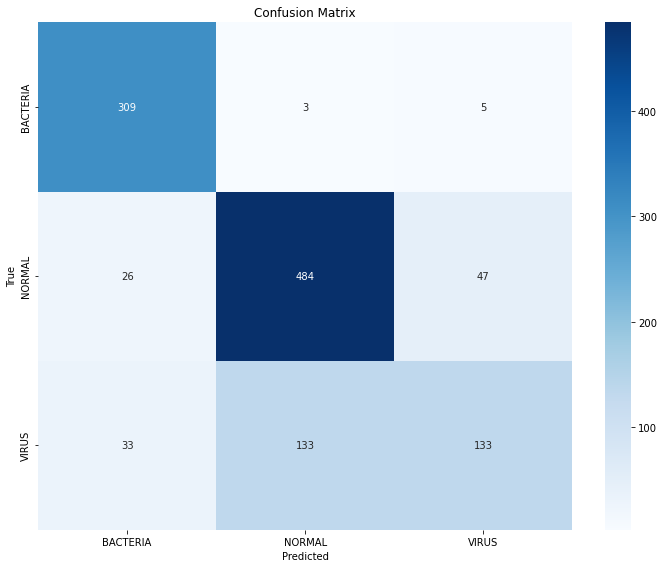

In [14]:
# Create confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()
plt.close()

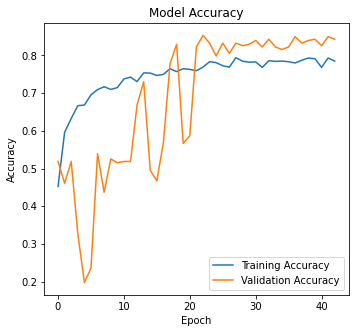

In [15]:
# Plot training history
plt.figure(figsize=(12, 5))
# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

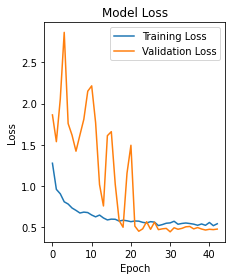

In [16]:
# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()
plt.close()

In [17]:
# Function to predict a single image
def predict_image(image_path, model, class_names):
    img = tf.keras.preprocessing.image.load_img(
        image_path, target_size=IMAGE_SIZE
    )
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = img_array / 255.0  # Rescale
    img_array = np.expand_dims(img_array, axis=0)  # Create batch

    # Make prediction
    predictions = model.predict(img_array)
    predicted_class_idx = np.argmax(predictions[0])
    predicted_class = class_names[predicted_class_idx]

    # Print results
    print(f"Predicted class: {predicted_class}")
    print("Class probabilities:")
    for i, class_name in enumerate(class_names):
        print(f"{class_name}: {predictions[0][i]:.4f}")

    return predicted_class, predictions[0]

In [18]:
# Save the model architecture and weights
vrnn_model.save('vrnn_chest_xray_model.keras')
print("Model saved to 'vrnn_chest_xray_model.keras'")

Model saved to 'vrnn_chest_xray_model.keras'
